In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [2]:
zoneDict = pd.read_csv('../../processedData/ZonetoComm24.csv')
# del zoneDict['Unnamed: 0']
zoneDict = zoneDict.rename(columns={'start_id':'DOLocationID'})
zoneDict

,DOLocationID,start_community
0,1,0.0
1,2,4.2
2,3,2.1
3,4,0.2
4,5,5.1
...,...,...
258,259,2.1
259,260,4.3
260,261,0.2
261,262,3.0


In [3]:
def getTimeSeries(df):
    table = pd.pivot_table(df, values='vehicle_count', index=['Date','Hour'],
                    columns=['start_community'], aggfunc=np.sum, fill_value=0)
    return table

In [4]:
def ResidinAnomaly(hub,method):
    label = pd.read_csv('../../processedData/'+hub+'VehicleByHour.csv')
    label = label.merge(zoneDict, on='DOLocationID')
    label = getTimeSeries(label)
    label = label.reset_index()
    label.columns = [str(col) for col in label.columns]

    prediction = pd.read_csv('../../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction['DOLocationID'] = prediction['DOLocationID'].astype(int)
    prediction = prediction.merge(zoneDict, on='DOLocationID')
    prediction = getTimeSeries(prediction)
    prediction = prediction.reset_index()
    prediction.columns = [str(col) for col in prediction.columns]

    label = label.merge(prediction[['Date','Hour']],on=['Date','Hour'],how='inner')
    label_value = label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])].values
    selectedColumn = sorted([str(x) for x in prediction.columns if x not in ['Date', 'Hour']])

    prediction_value = prediction[[str(col) for col in selectedColumn]].values

    events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
    label_anomaly = events.merge(label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])+['Date']],
                                 how='inner',on='Date')

    prediction_anomaly = events.merge(prediction[[str(col) for col in selectedColumn]+['Date']],how='inner',on='Date')
    label_anomaly_value = label_anomaly[[x for x in label_anomaly.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    prediction_anomaly_value = prediction_anomaly[[x for x in prediction_anomaly.columns 
                                                         if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    mask = label['Date'].isin(events['Date'])
    label_normal = label[~mask]
    label_normal_value = label_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()
    mask = prediction['Date'].isin(events['Date'])
    prediction_normal = prediction[~mask]
    prediction_normal_value = prediction_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()



    resid_anomaly_rate = (label_anomaly_value-prediction_anomaly_value+1)/(label_anomaly_value+1)
    resid_anomaly_rate = resid_anomaly_rate.merge(events, on='Date')
    resid_anomaly_rate = pd.melt(resid_anomaly_rate, id_vars=['Date','Type','Name'],var_name='DOLocationID',value_name='resid')
    
    resid_normal_rate = (label_normal_value-prediction_normal+1)/(label_normal_value+1)
    resid_normal_rate = pd.DataFrame(resid_normal_rate.mean(axis=0),columns=['resid'])

    return (resid_anomaly_rate, resid_normal_rate)

In [5]:
hub= 'JFK'
method = 'PCA6'

In [6]:
resid_anomaly_rate, resid_normal_rate = ResidinAnomaly(hub,method)

In [7]:
zones = gpd.read_file('../../Data/NYC Taxi Zones.geojson')
zones['location_id'] = zones['location_id'].astype(int)
zones = zones.merge(zoneDict,left_on='location_id',right_on='DOLocationID')
zones = zones.dissolve(by = 'start_community').reset_index()
zones = zones[['start_community', 'geometry']]
zones['start_community'] = 'zone' + zones['start_community'].astype(str)


In [8]:
resid_anomaly_rate['DOLocationID'] = 'zone' + resid_anomaly_rate['DOLocationID'].astype(str)

In [9]:
zones.merge(resid_anomaly_rate,
            left_on='start_community',right_on='DOLocationID').to_file('ResidAnomalyMap.geojson',driver='GeoJSON')

In [10]:
resid_normal_rate.index = 'zone' + resid_normal_rate.index.astype(str)
zones.merge(resid_normal_rate,
            left_on='start_community',right_index=True).to_file('ResidNormalMap.geojson',driver='GeoJSON')

In [11]:
events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
events

,Type,Name,Date
0,National Holiday,New Year's Day,2018-01-01
1,Extreme Weather,Blizzard,2018-01-04
2,Extreme Weather,Blizzard,2018-01-05
3,Airport Event,Major Delay,2018-01-06
4,National Holiday,"Martin Luther King, Jr. Day",2018-01-15
5,National Holiday,Washington's Birthday,2018-02-19
6,Extreme Weather,Snow Storm,2018-03-21
7,Extreme Weather,Snow Storm,2018-03-22
8,Extreme Weather,Thunderstorm,2018-05-15
9,National Holiday,Memorial Day,2018-05-28


In [12]:
resid_anomaly_rate_map = zones.merge(resid_anomaly_rate,
            left_on='start_community',right_on='DOLocationID')
resid_anomaly_rate_map.head()

,start_community,geometry,Date,Type,Name,DOLocationID,resid
0,zone0.0,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",2018-01-01,National Holiday,New Year's Day,zone0.0,-0.243681
1,zone0.0,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",2018-01-04,Extreme Weather,Blizzard,zone0.0,-0.135425
2,zone0.0,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",2018-01-05,Extreme Weather,Blizzard,zone0.0,-0.202190
3,zone0.0,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",2018-01-06,Airport Event,Major Delay,zone0.0,0.154991
4,zone0.0,"MULTIPOLYGON (((-74.18445 40.69500, -74.18449 ...",2018-01-15,National Holiday,"Martin Luther King, Jr. Day",zone0.0,-0.017341


In [13]:
def GMMBIC(matrix):

    bic = []
    for ncomp in range(2,6):
        gm=GaussianMixture(n_components=ncomp,n_init=100,max_iter=1000,random_state=0)
        labels = gm.fit_predict(matrix)
        score = gm.bic(matrix)
        bic += [score]
#         print(ncomp,score)
#     print('------------------------')
    GMMComp = np.array(bic).argmin() + 2
#         GMMBIC = np.array(bic).min()
    print('GMM in %s component has the lowest BIC value'%GMMComp)
    return GMMComp

In [14]:
df = pd.pivot_table(resid_anomaly_rate,index='Date',values=['resid'],columns=['DOLocationID'])
X = df.values
GMMBIC(X)

GMM in 2 component has the lowest BIC value


2

In [15]:
gm=GaussianMixture(n_components=2,n_init=100,max_iter=1000,random_state=0)
labels = gm.fit_predict(X)

In [16]:
events = pd.read_csv('/home/mingyi/Dropbox/DOE_Anomaly_Detection/%sEvents.csv'%hub.upper())
events['label'] = labels

In [17]:
events.loc[events['label']==1]

,Type,Name,Date,label
0,National Holiday,New Year's Day,2018-01-01,1
2,Extreme Weather,Blizzard,2018-01-05,1
3,Airport Event,Major Delay,2018-01-06,1
4,National Holiday,"Martin Luther King, Jr. Day",2018-01-15,1
5,National Holiday,Washington's Birthday,2018-02-19,1
8,Extreme Weather,Thunderstorm,2018-05-15,1
9,National Holiday,Memorial Day,2018-05-28,1
11,Airport Event,Major Delay,2018-07-23,1
12,National Holiday,Labour Day,2018-09-03,1
15,Extreme Weather,Storm,2018-11-15,1


In [18]:
df = df.droplevel(0, axis=1)
df['label'] = labels

In [19]:
df.groupby(['label']).sum()

DOLocationID,zone0.0,zone0.1,zone0.2,zone1.0,zone1.1,zone1.2,zone1.3,zone2.0,zone2.1,zone2.2,...,zone4.0,zone4.1,zone4.2,zone4.3,zone4.4,zone4.5,zone5.0,zone5.1,zone5.2,zone5.3
label,,,,,,,,,,,,,,,,,,,,,
0,-2.415137,-2.293023,-2.468505,0.338481,-1.680031,-0.190702,-0.668798,-0.137028,-0.968239,-1.131724,...,8.823385,-0.059082,0.439904,-0.432294,0.580402,-0.164422,-1.855369,0.758893,2.512036,1.449926
1,-0.067306,0.932510,0.732650,-0.058669,0.450489,-0.444824,0.011982,0.216680,-0.101438,0.148063,...,8.646766,0.296309,-0.040635,0.850518,0.093718,0.686744,0.647621,-1.388763,-2.195240,-1.816082


In [20]:
# residual in all days

path = "/home/mingyi/Dropbox/DOE_Anomaly_Detection/GMMDataset/selected/RFCV/%sPCA6RFCVResidDailyAggregated.csv"%hub
resid = pd.read_csv(path)
matrix = resid.drop(columns=['Date']).values

In [21]:
path = "/home/mingyi/Dropbox/DOE_Anomaly_Detection/GMMDataset/selected/GMMIteration/RFCV/%sPCA6RFCVResidAnomalyDetectionIterationOutput.csv"%hub
iterationDF = pd.read_csv(path)

In [22]:
iterationDF

,Date,2-0.0,2-0.01,2-0.02,2-0.03,2-0.04,2-0.05,2-0.06,2-0.07,2-0.08,...,2-0.9,2-0.91,2-0.92,2-0.93,2-0.94,2-0.95,2-0.96,2-0.97,2-0.98,2-0.99
0,2018-01-01,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,2018-01-02,False,False,False,False,False,False,False,False,True,...,True,True,True,True,True,True,True,True,True,True
2,2018-01-03,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
3,2018-01-04,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,2018-01-05,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2018-12-27,False,False,False,False,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
361,2018-12-28,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
362,2018-12-29,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
363,2018-12-30,False,False,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [23]:
iterationDF = iterationDF[[col for col in iterationDF.columns if '2-' in col]+['Date']]

In [24]:
iterationDF.columns = [col+'0' if len(col)<6 and col!='Date' else col for col in iterationDF.columns ]

In [25]:
events['Anomaly'] = True
events = events[['Anomaly','Date']].merge(iterationDF[['Date']],on='Date',how='right').fillna(False).sort_values(by='Date')

In [26]:
def ResidinAnomaly(hub,method,events,normalization='log'):
    label = pd.read_csv('../../processedData/'+hub+'VehicleByHour.csv')
    label = label.merge(zoneDict, on='DOLocationID')
    label = getTimeSeries(label)
    label = label.reset_index()
    label.columns = [str(col) for col in label.columns]

    prediction = pd.read_csv('../../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction['DOLocationID'] = prediction['DOLocationID'].astype(int)
    prediction = prediction.merge(zoneDict, on='DOLocationID')
    prediction = getTimeSeries(prediction)
    prediction = prediction.reset_index()
    prediction.columns = [str(col) for col in prediction.columns]

    label = label.merge(prediction[['Date','Hour']],on=['Date','Hour'],how='inner')
    label_value = label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])].values
    selectedColumn = sorted([str(x) for x in prediction.columns if x not in ['Date', 'Hour']])

    prediction_value = prediction[[str(col) for col in selectedColumn]].values

    label_anomaly = events.merge(label[sorted([str(x) for x in label.columns if x not in ['Date', 'Hour']])+['Date']],
                                 how='inner',on='Date')

    prediction_anomaly = events.merge(prediction[[str(col) for col in selectedColumn]+['Date']],how='inner',on='Date')
    label_anomaly_value = label_anomaly[[x for x in label_anomaly.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    prediction_anomaly_value = prediction_anomaly[[x for x in prediction_anomaly.columns 
                                                         if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()

    mask = label['Date'].isin(events['Date'])
    label_normal = label[~mask]
    label_normal_value = label_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()
    mask = prediction['Date'].isin(events['Date'])
    prediction_normal = prediction[~mask]
    prediction_normal_value = prediction_normal[[x for x in label_normal.columns 
                                        if x not in ['Hour','Type','Name']]].\
                                        groupby(['Date']).sum()


    if normalization == 'log':
        resid_anomaly_rate = np.log((label_anomaly_value+1)/(prediction_anomaly_value+1))
    
        resid_normal_rate = np.log((label_normal_value+1)/(prediction_normal_value+1))
        
    elif normalization == 'rate':
        resid_anomaly_rate = (label_anomaly_value-prediction_anomaly_value+1)/(label_anomaly_value+1)
    
        resid_normal_rate = (label_normal_value-prediction_normal_value+1)/(label_normal_value+1)
    
    resid_anomaly_rate = resid_anomaly_rate.merge(events, on='Date')
    resid_anomaly_rate = pd.melt(resid_anomaly_rate, id_vars=['Date'],var_name='DOLocationID',value_name='resid')
    resid_normal_rate = pd.DataFrame(resid_normal_rate.mean(axis=0),columns=['resid'])
    
    return (resid_anomaly_rate, resid_normal_rate)

In [27]:
def dataPrep(hub,method):
    label = pd.read_csv('../../processedData/'+hub+'VehicleByHour.csv')
    
    prediction = pd.read_csv('../../prediction/'+hub+method+'.csv')
    
    label = pd.read_csv('../../processedData/'+hub+'VehicleByHour.csv')
    label.columns = [str(col) for col in label.columns]
    label.DOLocationID = label.DOLocationID.astype(str)
    label = label.rename(columns={'vehicle_count':'label'})
    prediction = pd.read_csv('../../prediction/'+hub+method+'.csv')
    prediction = pd.melt(prediction, id_vars=['Date','Hour'],var_name='DOLocationID',value_name='vehicle_count')
    prediction.DOLocationID = prediction.DOLocationID.astype(str)
    prediction = prediction.rename(columns={'vehicle_count':'prediction'})
    df = label.merge(prediction,on=['Date','Hour','DOLocationID'])
    return df
def elbow(df,thre,MAEiteration):
    events = iterationDF.loc[iterationDF['2-0.%s'%str(thre).zfill(2)]==True][['Date']]
    mask = df['Date'].isin(events['Date'])
    df_normal = df[~mask]
    df_anomaly = df.loc[df['Date'].isin(events['Date'])]
    MAEanomaly = mean_absolute_error(df_anomaly.label,df_anomaly.prediction)
    MAErest = mean_absolute_error(df_normal.label,df_normal.prediction)
    MAEall = mean_absolute_error(df.label,df.prediction)
    MAEiteration[str(thre)] = [MAEanomaly,MAErest,MAEall]
    return MAEiteration


In [28]:
MAEiteration = {}
df = dataPrep('JFK','PCA6')
for thre in range(1,100):
    MAEiteration = elbow(df,thre,MAEiteration)

In [29]:
MAEdf = pd.DataFrame(MAEiteration).T
MAEdf.columns = ['anomaly_MAE','rest_MAE','all_MAE']
MAEdf['diff_MAE'] = MAEdf['rest_MAE'] - MAEdf['anomaly_MAE']

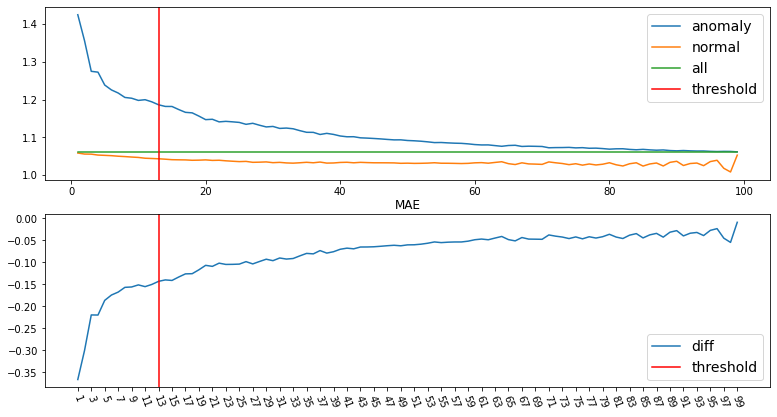

In [30]:
fig,ax = plt.subplots(2,1,figsize=(13,7))
plt.title('MAE')
ax[0].plot(range(1,100),MAEdf['anomaly_MAE'],label='anomaly')
ax[0].plot(range(1,100),MAEdf['rest_MAE'],label='normal')
ax[0].plot(range(1,100),MAEdf['all_MAE'],label='all')
_ = plt.xticks(np.arange(1,100,2),rotation=-70)
ax[0].axvline(x=13,color='red',label='threshold')
ax[0].legend(fontsize=14)
# ax[0].title('MAE')

ax[1].plot(range(1,100),MAEdf['diff_MAE'],label='diff')
ax[1].axvline(x=13,color='red',label='threshold')
_ = plt.xticks(np.arange(1,100,2),rotation=-70)
ax[1].legend(fontsize=14)



In [31]:
# r2 elbow
def elbow(df,thre,MAEiteration):
    events = iterationDF.loc[iterationDF['2-0.%s'%str(thre).zfill(2)]==True][['Date']]
    mask = df['Date'].isin(events['Date'])
    df_normal = df[~mask]
    df_anomaly = df.loc[df['Date'].isin(events['Date'])]
    MAEanomaly = r2_score(df_anomaly.label,df_anomaly.prediction)
    MAErest = r2_score(df_normal.label,df_normal.prediction)
    MAEall = r2_score(df.label,df.prediction)
    MAEiteration[str(thre)] = [MAEanomaly,MAErest,MAEall]
    return MAEiteration

In [32]:
r2iteration = {}
df = dataPrep('JFK','PCA6')
for thre in range(1,100):
    r2iteration = elbow(df,thre,r2iteration)

In [33]:
r2df = pd.DataFrame(r2iteration).T
r2df.columns = ['anomaly_MAE','rest_MAE','all_MAE']
r2df['diff'] = r2df['rest_MAE'] - r2df['anomaly_MAE']

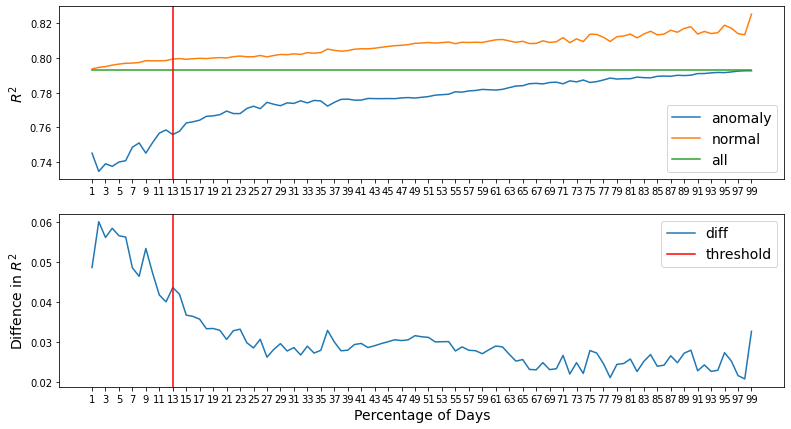

In [72]:
fig,ax = plt.subplots(2,1,figsize=(13,7))

ax[0].plot(range(1,100),r2df['anomaly_MAE'],label='anomaly')
_ = ax[0].set_xticks(np.arange(1,100,2))
ax[0].plot(range(1,100),r2df['rest_MAE'],label='normal')
ax[0].plot(range(1,100),r2df['all_MAE'],label='all')
ax[0].legend(fontsize=14)
ax[0].axvline(x=13,color='red',label='threshold')
ax[0].set_ylabel('$R^2$',fontsize=14)
ax[1].plot(range(1,100),r2df['diff'],label='diff')
ax[1].axvline(x=13,color='red',label='threshold')
ax[1].set_ylabel('Diffence in $R^2$',fontsize=14)
ax[1].set_xlabel('Percentage of Days',fontsize=14)
_ = ax[1].set_xticks(np.arange(1,100,2))
plt.legend(fontsize=14)
plt.savefig('threhold.png',dpi=300,bbox_inches='tight')

In [35]:
# log residual
def elbow(df,thre,logresiditeration):
    events = iterationDF.loc[iterationDF['2-0.%s'%str(thre).zfill(2)]==True][['Date']]
    mask = df['Date'].isin(events['Date'])
    df_normal = df[~mask]
    df_anomaly = df.loc[df['Date'].isin(events['Date'])]
    logresidanomaly = np.mean(np.log((df_anomaly.prediction.values - df_anomaly.label.values)-
                             min(df_anomaly.prediction.values - df_anomaly.label.values)+1))
    logresidrest = np.mean(np.log((df_normal.prediction.values - df_normal.label.values)-
                             min(df_normal.prediction.values - df_normal.label.values)+1))
    logresidall = np.mean(np.log((df.prediction.values - df.label.values)-
                             min(df.prediction.values - df.label.values)+1))

    logresiditeration[str(thre)] = [logresidanomaly,logresidrest,logresidall]
    return logresiditeration

In [36]:
logresiditeration = {}
df = dataPrep('JFK','PCA6')
for thre in range(1,100):
    logresiditeration = elbow(df,thre,logresiditeration)

In [37]:
logresiddf = pd.DataFrame(logresiditeration).T
logresiddf.columns = ['anomaly_logResid','rest_logResid','all_logResid']
logresiddf['diff'] = logresiddf['rest_logResid'] - logresiddf['anomaly_logResid']

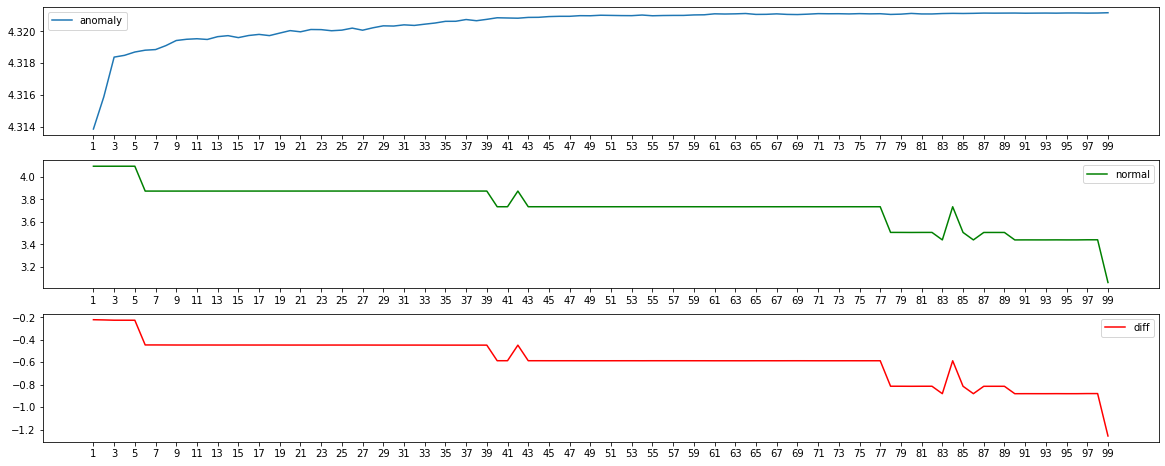

In [38]:
fig,ax = plt.subplots(3,1,figsize=(20,8))
ax[0].plot(range(1,100),logresiddf['anomaly_logResid'],label='anomaly')

# ax[0].plot(range(1,100),logresiddf['all_logResid'],label='all')
ax[0].legend()
_ = ax[0].set_xticks(np.arange(1,100,2))
ax[1].plot(range(1,100),logresiddf['rest_logResid'],label='normal',color='green')
ax[1].legend()
_ = ax[1].set_xticks(np.arange(1,100,2))

ax[2].plot(range(1,100),logresiddf['diff'],label='diff',color='red')
_ = ax[2].set_xticks(np.arange(1,100,2))
plt.legend()

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [118]:
def plotinthre(thre):
    events = iterationDF.loc[iterationDF['2-0.%s'%str(thre).zfill(2)]==True][['Date']]
    resid_anomaly_rate, resid_normal_rate = ResidinAnomaly(hub,method,events,normalization='rate')
#     resid_anomaly_log, resid_normal_log = ResidinAnomaly(hub,method,events,normalization='log')
    df = pd.pivot_table(resid_anomaly_rate,index='Date',values=['resid'],columns=['DOLocationID'])
    X = df.values
    comp = GMMBIC(X)
    gm=GaussianMixture(n_components=comp,n_init=100,max_iter=1000,random_state=0)
    labels = gm.fit_predict(X)
    events['label'] = labels
    resid_anomaly_rate['DOLocationID'] = 'zone' + resid_anomaly_rate['DOLocationID'].astype(str)
        
    df = df.droplevel(0, axis=1)
    df['label'] = labels
    
    zoneresid = df.groupby(['label']).agg('mean').reset_index()
    zoneresid = pd.melt(zoneresid,id_vars=['label'],var_name='DOLocationID',value_name='resid')
#     print(zoneresid)
    zoneresid['DOLocationID'] = 'zone'+zoneresid['DOLocationID']
    resid_anomaly_rate_map = zones.merge(zoneresid.groupby(['label','DOLocationID']).sum().reset_index(),
            left_on='start_community',right_on='DOLocationID') 
    vmin, vmax, vcenter = -0.7, 0.5, 0
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cmap = 'RdBu_r'
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    plt.tight_layout()
    
    fig,ax = plt.subplots(1, comp+1,figsize=(14,3))

    
    for i in range(comp):
        plot_df = resid_anomaly_rate_map.loc[resid_anomaly_rate_map['label']==i]
        plot_df.plot(column='resid', cmap=cmap, norm=norm, legend=False,ax=ax[i+1])
        ax[i+1].set_title('Cluster %s'%i,fontsize=14)
        ax[i+1].axis('off')
        
    divider = make_axes_locatable(ax[0])
    ax[0].axis('off')

    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(cbar, cax=cax)
    cb.ax.tick_params(labelsize=9)
    fig.tight_layout()
    plt.savefig('impact.png',dpi=300,bbox_inches='tight')
    resid_anomaly_rate_map = resid_anomaly_rate_map.rename(columns={'resid':'resid%s'%thre})
    
    # plot p-value
    residMean = df.groupby(['label']).mean().reset_index()
#     print(residMean)
#     print()
    vmin, vmax, vcenter = 0, 1, 0.5
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cmap = 'RdYlGn_r'
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    fig,ax = plt.subplots(1, comp+1,figsize=(14,3))
    for i in range(comp):
        
        for col in df.columns:
            zoneRate = {}
            if col != 'label':
#                 print(i,col)
                if residMean.loc[residMean['label']==i,col].values[0] > 0:
                    rate = (df.loc[df['label']==i,col]>0).sum()/len(df.loc[df['label']==i])
                else:
                    rate = (df.loc[df['label']==i,col]<0).sum()/len(df.loc[df['label']==i])
                zoneRate[col] = rate   
                zoneRate = pd.DataFrame(zoneRate.items(),columns=['DOLocationID','rate'])
                zoneRate['DOLocationID'] = 'zone'+zoneRate['DOLocationID']
#                 print(zoneRate)
                plot_df = resid_anomaly_rate_map.drop_duplicates(subset=['DOLocationID']).\
                            merge(zoneRate,on='DOLocationID',how='right')
#                 print(plot_df)
                plot_df.plot(column='rate', cmap=cmap, norm=norm, legend=False,ax=ax[i+1])
                ax[i+1].set_title('Cluster %s'%i)
                ax[i+1].axis('off')
            
    divider = make_axes_locatable(ax[0])
    ax[0].axis('off')
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(cbar, cax=cax)
    cb.ax.tick_params(labelsize=9)
    fig.tight_layout()
    plt.savefig('significance.png',dpi=300,bbox_inches='tight')
    del resid_anomaly_rate_map['geometry']
#     del resid_anomaly_rate_map['start_community']
    return df, resid_anomaly_rate_map

GMM in 4 component has the lowest BIC value
    label DOLocationID     resid
0       0          0.0 -0.093728
1       1          0.0 -0.188980
2       2          0.0 -0.021102
3       3          0.0  0.039349
4       0          0.1  0.053052
..    ...          ...       ...
91      3          5.2  0.246312
92      0          5.3 -0.170209
93      1          5.3 -0.055162
94      2          5.3 -0.063159
95      3          5.3  0.292042

[96 rows x 3 columns]


<Figure size 432x288 with 0 Axes>

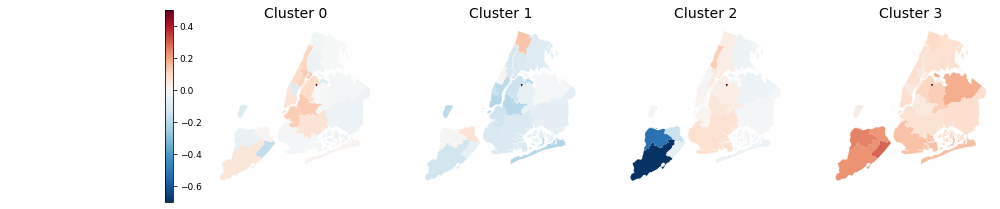

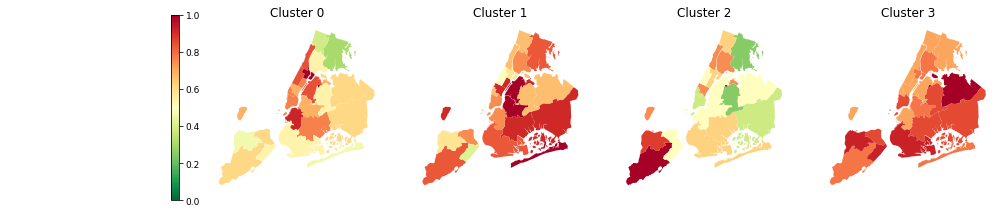

In [116]:
df,resid_anomaly_rate_map = plotinthre(13)

In [108]:
community = ['zone0.0','zone0.1','zone4.4']
selectedComm = resid_anomaly_rate_map.loc[(resid_anomaly_rate_map['start_community'].isin(community))&
                           (resid_anomaly_rate_map['label']==1)]
print(selectedComm['resid13'].mean())
print(selectedComm['resid13'].std())

-0.09352459456441115
0.039030987853605696


In [130]:
community = ['4.0','4.1','4.3','1.2','5.2','5.3']
selectedComm = df[community+['label']].loc[(df['label']==3)]
print(selectedComm[community].values.flatten().mean())
print(selectedComm[community].values.flatten().std())

0.307955627403466
0.2874153819481121


In [136]:
community = ['0.1','3.0','4.5','1.3','1.0','4.2','4.4']
selectedComm = df[community+['label']].loc[(df['label']==1)]
print(selectedComm[community].values.flatten().mean())
print(selectedComm[community].values.flatten().std())

-0.15170453569056314
0.1714311711229304


In [140]:
community = ['3.1','1.1']
selectedComm = df[community+['label']].loc[(df['label']==1)]
print(selectedComm[community].values.flatten().mean())
print(selectedComm[community].values.flatten().std())

-0.12900242623472233
0.20923463655140137


In [141]:
community = ['5.1','1.1']
selectedComm = df[community+['label']].loc[(df['label']==2)]
print(selectedComm[community].values.flatten().mean())
print(selectedComm[community].values.flatten().std())

-0.3403277260885369
0.48260279598432476


/home/mingyi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


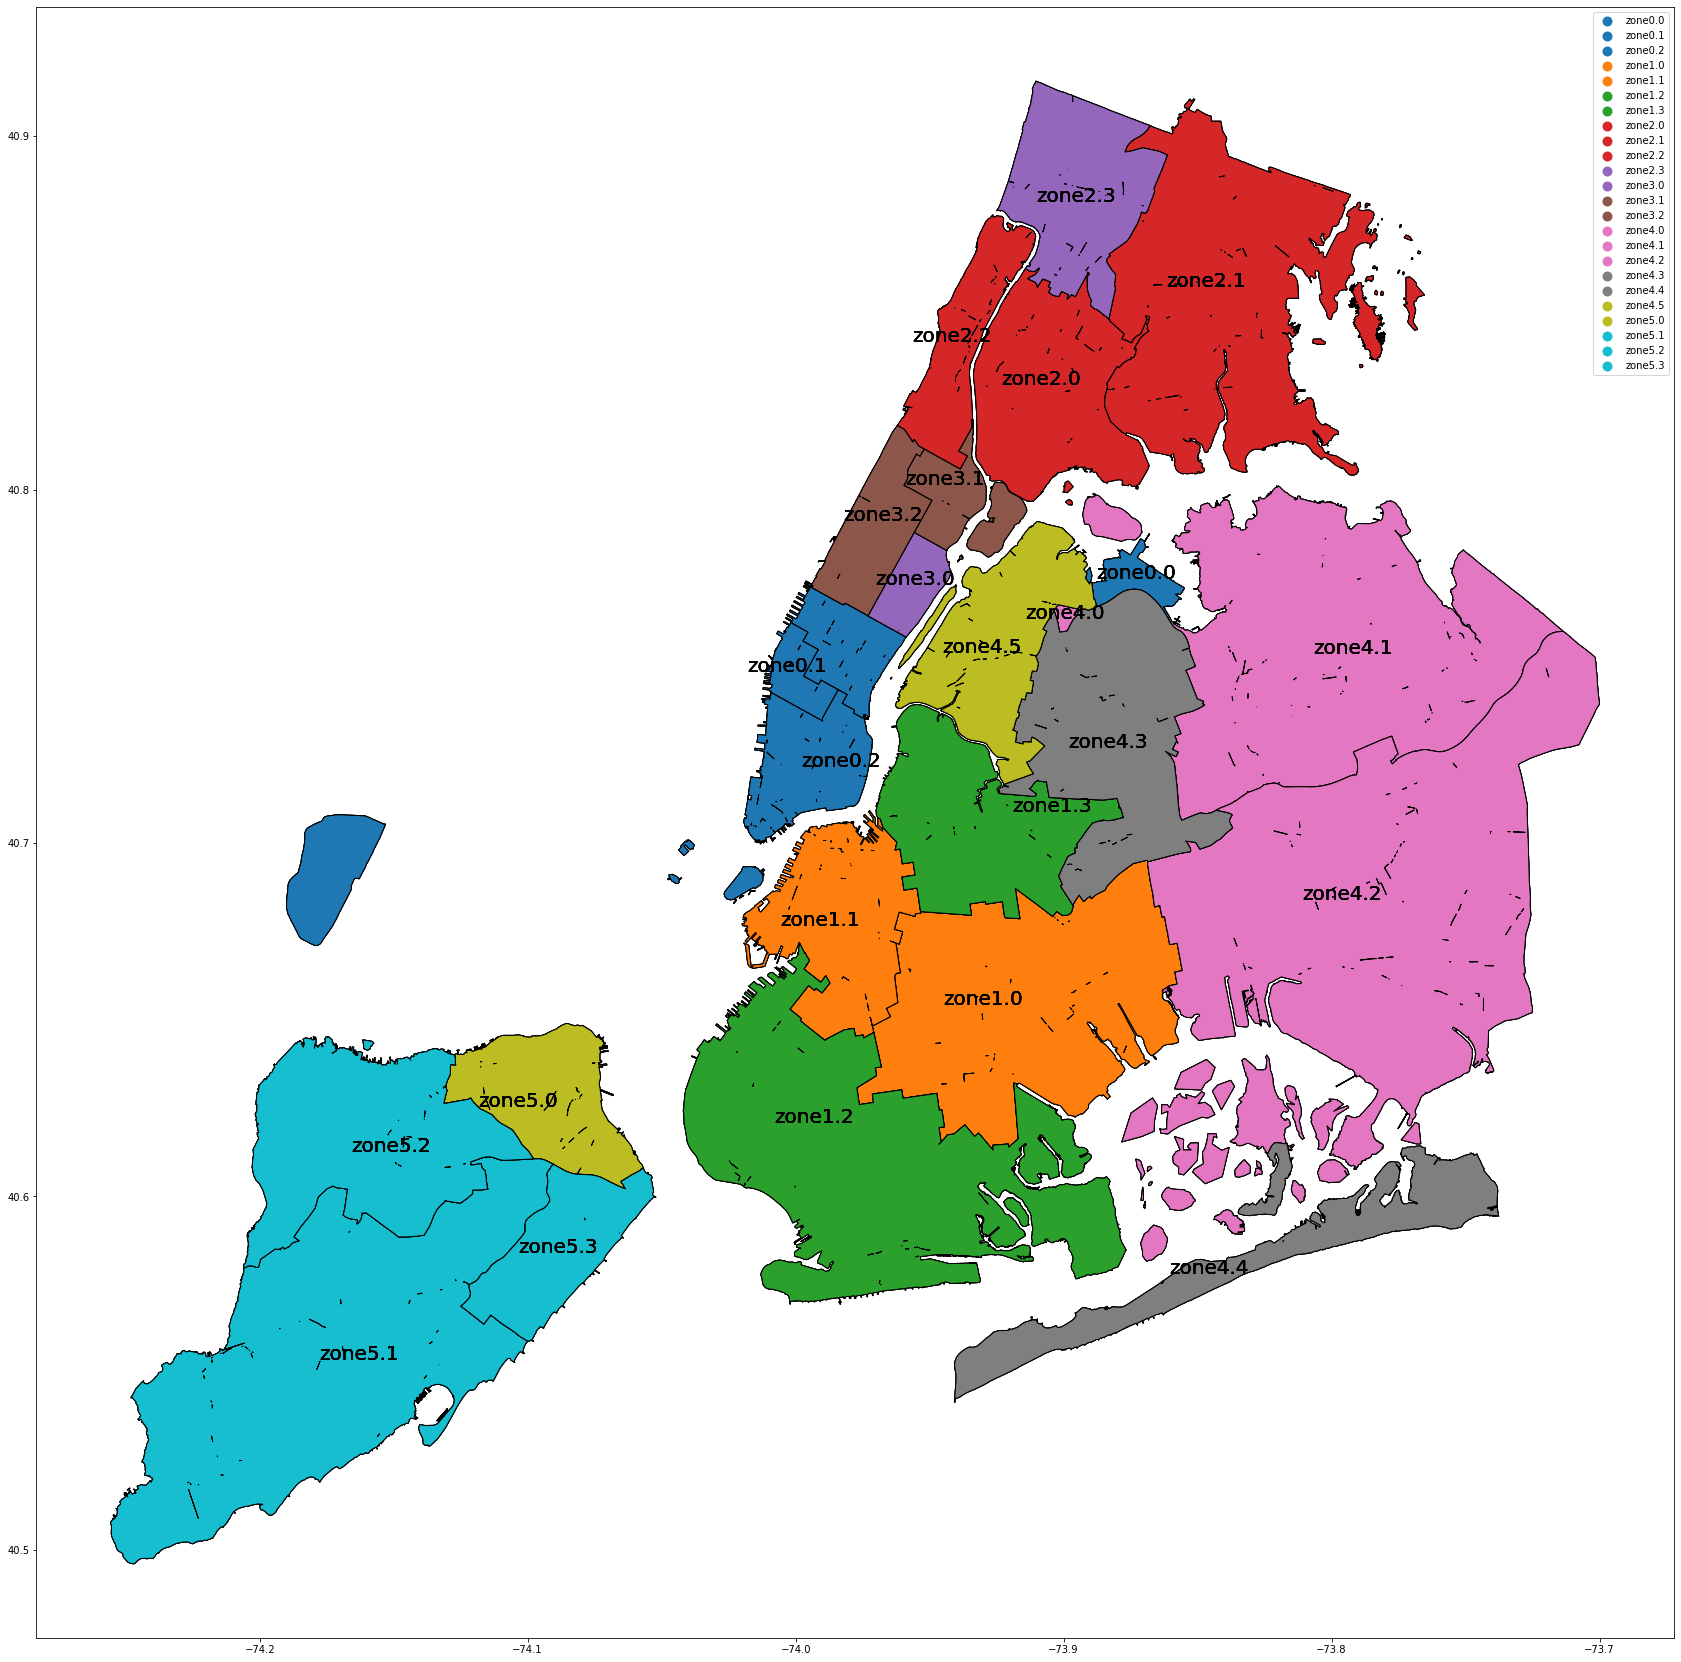

In [101]:
c = zones.merge(resid_anomaly_rate_map,
            left_on='start_community',right_on='DOLocationID')
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

c.plot(figsize=(30,30),edgecolor='k',column='start_community_x',legend=True)

for idx, row in c.iterrows():
    plt.annotate(s=row['start_community_x'], xy=row['coords'],
                 horizontalalignment='center',fontsize=20)

In [105]:
community = ['zone4.1','zone4.2','zone4.3','zone1.2','zone5.2','zone5.3']
selectedComm = resid_anomaly_rate_map.loc[(resid_anomaly_rate_map['start_community'].isin(community))&
                           (resid_anomaly_rate_map['label']==0)]
print(selectedComm['resid13'].mean())
print(selectedComm['resid13'].std())

0.1788407516764897
0.08348706939373979


In [147]:

for i in df.loc[df['label']==3].index.values.tolist():
    print(i)

2018-01-04
2018-01-06
2018-04-08
2018-04-09
2018-07-08
2018-07-23
2018-08-03
2018-08-27
2018-09-02
2018-09-03
2018-09-04
2018-09-12
2018-11-16
2018-11-26


In [45]:
df

DOLocationID,Date,0.0,0.1,0.2,1.0,1.1,1.2,1.3,2.0,2.1,...,4.1,4.2,4.3,4.4,4.5,5.0,5.1,5.2,5.3,label
0,2018-01-01,-0.218482,0.191940,0.144941,-0.193391,0.081002,-0.119555,-0.032734,-0.216553,-0.067639,...,-0.050316,-0.190294,0.025124,-0.107730,0.003066,0.346236,-0.264967,-0.003433,0.139992,1
1,2018-01-02,-0.077367,0.242301,0.203444,0.021123,0.102481,-0.054895,0.145826,-0.057871,0.155379,...,-0.091399,-0.128670,-0.122360,-0.011602,0.071626,0.036702,0.059125,-0.423752,-0.104240,2
2,2018-01-03,-0.106299,0.040737,0.033501,0.021974,0.091276,0.021510,0.237491,0.138725,0.070949,...,-0.081572,-0.145832,0.048009,-0.030841,0.109707,0.153005,-0.170541,0.230164,-0.549085,1
3,2018-01-04,-0.127553,-0.188090,-0.255575,0.106726,-0.048243,0.114275,0.068773,-0.112807,0.095946,...,0.455627,0.538880,0.221361,0.194830,0.251982,-0.024735,0.209838,0.312535,0.291941,0
4,2018-01-06,0.168050,0.266609,0.138633,0.149787,0.295169,-0.090633,0.261289,0.021147,0.005980,...,0.270674,0.177646,0.602538,-0.072355,0.379989,0.361929,-0.196729,0.279042,0.068313,2
5,2018-01-07,0.068447,0.140798,0.104536,0.127418,0.136156,-0.056756,0.146930,-0.099243,0.062182,...,0.079987,0.106384,0.388816,-0.132192,0.184749,-0.475964,-0.422553,-0.716017,-0.101403,2
6,2018-01-08,0.166096,0.144036,0.034573,0.111038,-0.126103,0.021609,0.120254,0.176131,0.072981,...,0.071297,0.038447,0.368280,0.063905,0.215789,0.100591,-0.703801,-0.319934,-0.027005,2
7,2018-01-13,0.214736,0.241551,-0.048274,-0.035932,-0.031327,-0.166914,-0.040987,-0.058634,-0.151754,...,-0.022214,-0.114078,0.039726,-0.327827,-0.159840,0.077874,-0.115602,-0.222040,0.237062,3
8,2018-01-14,-0.137806,-0.047001,-0.202673,-0.096083,-0.047374,-0.053042,-0.127937,-0.198965,-0.112277,...,-0.072220,-0.055168,-0.103326,-0.187818,-0.070184,0.089504,-0.158609,0.181638,-0.657195,3
9,2018-01-15,-0.017457,0.089213,0.040856,-0.106349,-0.049826,-0.100206,-0.186111,-0.168986,-0.181261,...,-0.034131,-0.068661,-0.065574,-0.162072,-0.082184,0.330616,-0.399327,-0.376832,-0.734865,3
